In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates

# PRD analysis
## Objectives

### Isolate 2 different trends: just after irrigation, in between 2 irrigations
Exemple: 19/05/2022, 15:38/18:20 and  18/05/2022, 15:38/18:20 (in between 2 irrigations). 

### before irrigation the ET speeded up drastically;
 40 ml/5.55 hour. possible causes: the roots reached the zone under the outflow point (see photos) / it is not the ET but other change on the scale e.g. the plant "climbed up" on the horizontal rope (visually doesn't seem that this would mean so much weight)


In [120]:
sheet_id = '1GqDKU8fC0Pw_DQpUD-MBLpN-AXWrAzLuO1hABxxYIhc'
sheet_name = ['apr_6-11','apr_11-13','apr_13-21','apr_21-26','apr_28-may_2']

list_data_scale = []
for sn in sheet_name:
    url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sn}'
    data_scale_i = pd.read_csv(url, decimal=',')
    
    data_scale_i['abs_date'] = pd.to_datetime(data_scale_i['date'] + " " + data_scale_i['time'],
                                        infer_datetime_format=True)  
    
    #data_scale_i['abs_date'] = pd.to_datetime(data_scale_i['date'] + " " + data_scale_i['time'],
    #                                format="%d/%m/%Y %H:%M:%S")  
    
    datestr = data_scale_i['date'] + " " + data_scale_i['time']
    data_scale_i['abs_date'] = pd.to_datetime(data_scale_i['date'] + " " + data_scale_i['time'],
                                    format="%d/%m/%Y %H:%M") 
                                              
    #datetime.strptime(datestr, "%m/%d/%Y %H:%M")

    
    
    initial_date = data_scale_i['abs_date'][0]
    print(initial_date)
    
    dates = []
    for i in range(len(data_scale_i['time'])):
        dates.append(initial_date + pd.Timedelta(seconds=data_scale_i['sec'][i]))
        
    date_time = [t.strftime("%Y-%m-%d %H:%M:%S") for t in dates]
    
    data_scale_i['abs_date_new']=date_time
    data_scale_i['abs_date_new']= pd.to_datetime(data_scale_i['abs_date_new'])

    list_data_scale.append(data_scale_i)
    
    
df = pd.concat(list_data_scale, axis=0, ignore_index=False)



2022-04-06 17:36:00
2022-04-11 17:37:00
2022-04-13 18:48:00
2022-04-21 18:20:00
2022-04-28 17:23:00


[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'weight (kg)'),
 Text(0.5, 1.0, 'Raw data sheet apr_28-may_2')]

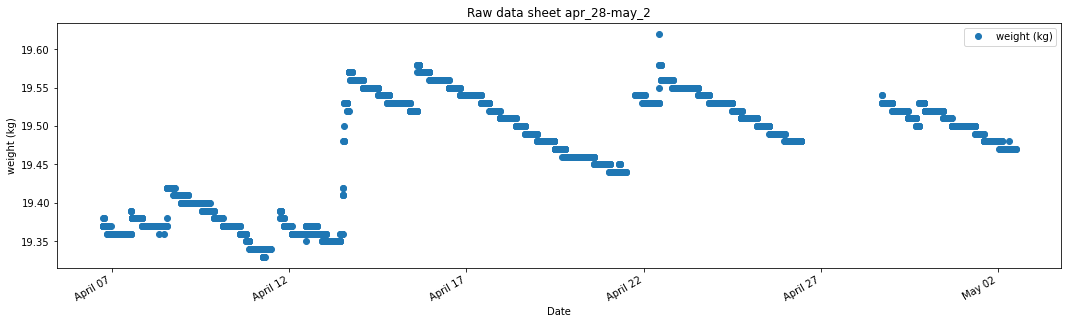

In [121]:
fig, ax = plt.subplots(figsize=(18, 5))

df.plot('abs_date_new', 'weight (kg)', style='o', ax=ax)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
#ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %d'))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))


# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="weight (kg)",
       title="Raw data sheet " + sheet_name[sheet_nb-1])



In [122]:
df['cumweight'] = df['weight (kg)'].cumsum()
#data_scale['rolling'] = data_scale['weight (kg)'].rolling(20).sum()
df['rolling'] = df['weight (kg)'].rolling(12).mean()

df['rolling_std'] = df['weight (kg)'].rolling(12).std()
df['diff'] = df['rolling'].diff()

diurn=[]
for d in df['abs_date_new']:
    #print(d)
    #print(int(d.strftime('%H')))
    if int(d.strftime('%H'))>=7 and int(d.strftime('%H'))<=19:
        diurn.append(True)
    else:
        diurn.append(False)

df['diurn'] = diurn  

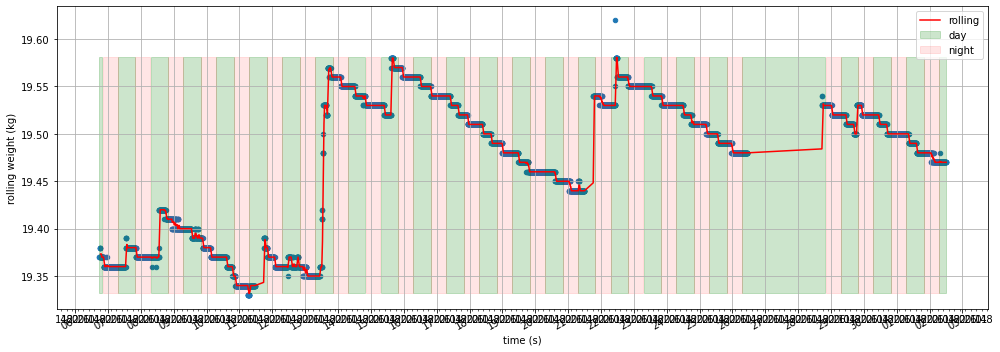

In [123]:
fig, ax = plt.subplots(figsize=(14, 5))

df.plot.scatter(x='abs_date_new',y='weight (kg)', ax=ax)
df.plot(x='abs_date_new',y='rolling', ax=ax, color='r')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

plt.gcf().autofmt_xdate()
ax.fill_between(df['abs_date_new'], df['rolling'].min(), df['rolling'].max(), where=df['diurn']==True,
                color='green', alpha=0.2, label='day')
ax.fill_between(df['abs_date_new'], df['rolling'].min(), df['rolling'].max(), where=df['diurn']==False,
                color='red', alpha=0.1, label='night')
plt.xlabel('time (s)')
plt.ylabel('rolling weight (kg)')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()
fig.savefig(sheet_name[sheet_nb-1]+'.png', 
            dpi=450,
            transparent=False)


In [124]:
# delete all positive variations
# cumsum during diurn/night

df['weight_diff']= df['weight (kg)'].diff()
df['weight_diff']

df_pos_diff = df[df['weight_diff'] >=0]
df_pos_diff = df[df['weight_diff'] >0]

len(df)-len(df_pos_diff)


6540

In [136]:
df_pos_diff
df_pos_diff.isna().sum()
#df_pos_diff.dropna(inplace=True)

date            0
time            0
sec             0
weight (kg)     0
abs_date        0
abs_date_new    0
cumweight       0
rolling         1
rolling_std     1
diff            1
diurn           0
weight_diff     0
dtype: int64

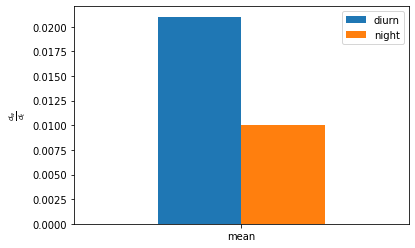

In [150]:
mean_diurn= df_pos_diff[df_pos_diff.loc[:,'diurn']==True]['weight_diff'].mean()
mean_day= df_pos_diff[df_pos_diff.loc[:,'diurn']==False]['weight_diff'].mean()

index = ['mean']
df = pd.DataFrame({'diurn': mean_diurn,
                   'night': mean_day}, index=index)
ax = df.plot.bar(rot=0,ylabel=r'$\frac{d_{w}}{d_{t}}$')